## Loading the data and libraries
Clone the github repository, download the data file, and import needed libraries.


In [1]:
#Copy code into CoLab space
!git clone https://github.com/6862-2021SP-team3/pytorch-normalizing-flows.git

fatal: destination path 'pytorch-normalizing-flows' already exists and is not an empty directory.


In [2]:
#Copy training data from online repository
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-12 19:23:17--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-12 19:23:17--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0acc478581eb78314a2c6c472.dl.dropboxusercontent.com/cd/0/inline/BMdr9H6zCTgIEp9ccu1cUEC8aA6Kg3w0cn0ptm0U5iiWmmiSeyNhE_iDyYT0zJW-u7upvk_nU7baGPrqQsbBDfTOZLAXR1dzu6nwlo5E0lvMzf7QggqxxGxz8uLuZAjss732c958bny9HjIUtGSW85NI/file# [following]
--2021-04-12 19:23:18--  https://uca0acc478581eb78314a2c6c472.dl.dropboxusercontent.com/cd/0/inline/BMdr9H6zCTgIEp9ccu1cUEC8aA6Kg3w0cn0ptm0U5iiWmmiSeyNhE_iDyYT0zJW-u7upvk_nU7baGPrqQsbBDfTOZLAXR1dzu6nw

In [3]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [4]:
#Add local modules to path
import sys
sys.path.insert(0,'/content/pytorch-normalizing-flows')


In [5]:
#Standard import statements
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from datetime import datetime

#Pytorch imports
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

#NFlow library imports
from nflib.flows import (
    AffineConstantFlow, AffineHalfFlow, MLP, 
    NormalizingFlow, NormalizingFlowModel,
)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Define the data class
The data class reads the downloaded `pi0.pkl` and save them in the varaiable `xz`, `x`, `z`. The `x` and `z` contains encoded particle codes, which are not necessary for the flow model. The `xwithoutPid` and `zwithoutPid` are the varaiables don't contain particle codes for one row. The method `sample` is defined to pick partial rows in given size, where the row indices are randomized.

In [6]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [7]:
xz = dataXZ()
z = xz.z
x = xz.x



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


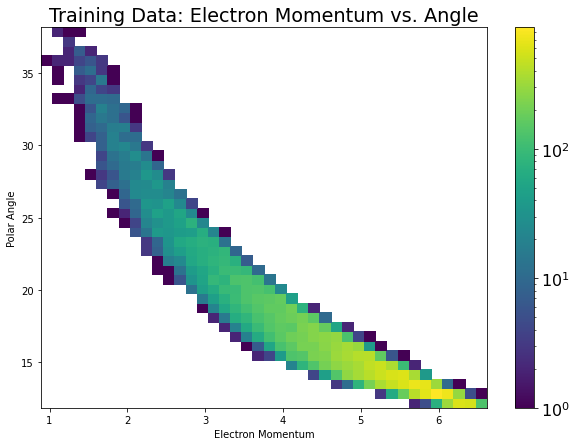

In [8]:
#Let's look at the data
sampleDict = xz.sample(30000) #Get a subset of the datapoints
x = sampleDict["xwithoutPid"][:, 0:2] #For now, only 
#print(x)
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Training Data: Electron Momentum vs. Angle')
x= x.detach().numpy()

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

In [9]:
sampleDict = xz.sample(100)
print(sampleDict["xz"][0])
print(sampleDict["xwithoutPid"][0])


[   3.8221188    19.039      -155.73906       1.            0.98214597
   30.09439     148.83942       2.            6.593721     14.563946
    9.3822565     3.            0.25586906   21.751389      6.4453745
    3.            3.8511868    19.03494    -155.74294       1.
    0.98896986   31.357748    149.03992       2.            6.1362925
   14.506874      9.122281      3.            0.18735075   21.66822
    6.2806497     3.        ]
tensor([   3.8221,   19.0390, -155.7391,    0.9821,   30.0944,  148.8394,
           6.5937,   14.5639,    9.3823,    0.2559,   21.7514,    6.4454])


## Construct a model
We try with a 2d example, electron momentum magnitude and polar angle only. The prior can be any constant distributions, or the parent distributions of `z`. At this stage, we look into the proof of concept, starting with 2d constant distribution. We firstly use the logistic distribution, which can be inverse transform sampled from sigmoid distribution. We pick Adam as our optimizer.

In [10]:
# construct a model
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# try with electron momentum magintude and polar angle only
prior = TransformedDistribution(Uniform(torch.zeros(2, device = device), torch.ones(2, device = device)), SigmoidTransform().inv) # Logistic distribution
#prior = MultivariateNormal(torch.zeros(2, device = device), torch.eye(2, device = device)) # Normal distribution
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model

model = NormalizingFlowModel(prior, flows, device = device)
model.to(device)


NormalizingFlowModel(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): AffineHalfFlow(
        (t_cond): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=24, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=24, out_features=24, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=24, out_features=24, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=24, out_features=1, bias=True)
          )
        )
      )
      (1): AffineHalfFlow(
        (t_cond): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=24, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=24, out_features=24, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=24, out_features=24, bias=True)
            (5): LeakyReLU(neg

In [11]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [12]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    x = x.to(device)
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))




Start Time = 19:23:44
On step 0 - loss 75213.20, Current Running Time = 0.06 seconds
On step 100 - loss 28817.03, Current Running Time = 2.21 seconds
On step 200 - loss 5973.47, Current Running Time = 4.31 seconds
On step 300 - loss 5262.63, Current Running Time = 6.35 seconds
On step 400 - loss 5021.25, Current Running Time = 8.44 seconds
On step 500 - loss 5124.57, Current Running Time = 10.51 seconds
On step 600 - loss 5188.53, Current Running Time = 12.55 seconds
On step 700 - loss 4761.01, Current Running Time = 14.59 seconds
On step 800 - loss 4769.28, Current Running Time = 16.64 seconds
On step 900 - loss 4538.04, Current Running Time = 18.68 seconds
On step 1000 - loss 4279.25, Current Running Time = 20.75 seconds
On step 1100 - loss 4268.14, Current Running Time = 22.82 seconds
On step 1200 - loss 4053.33, Current Running Time = 24.89 seconds
On step 1300 - loss 3674.74, Current Running Time = 26.96 seconds
On step 1400 - loss 3917.39, Current Running Time = 29.03 seconds
On 

Text(0, 0.5, 'Loss')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


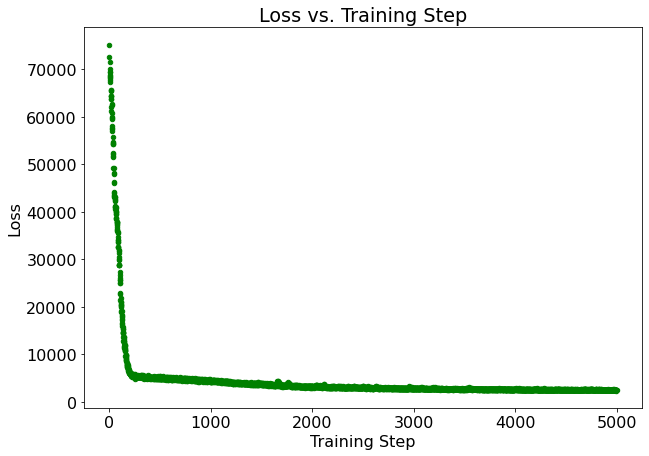

In [13]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(losses)),losses, c='g', s=20)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

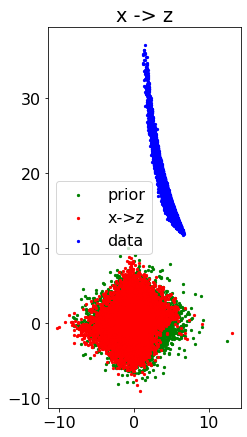

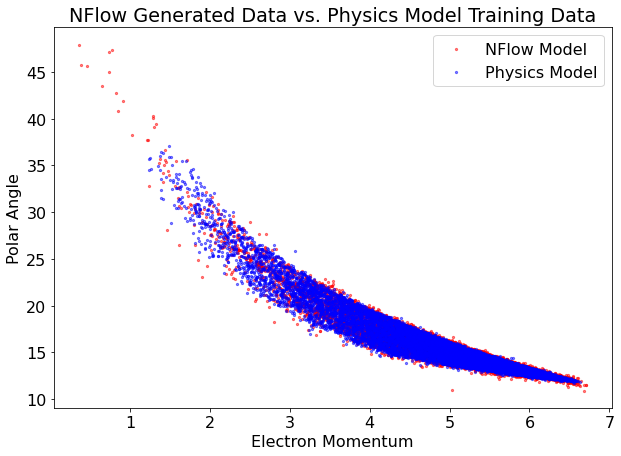

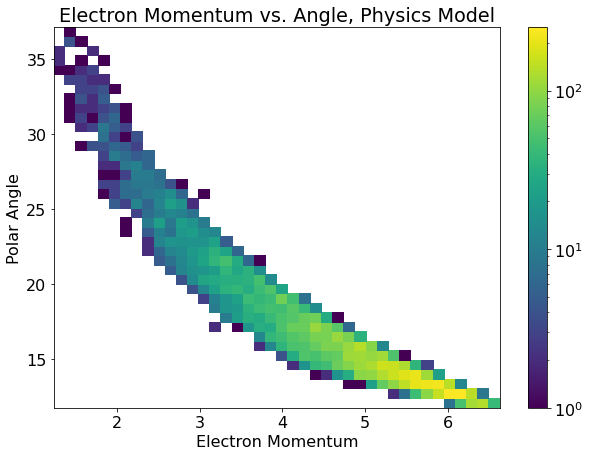

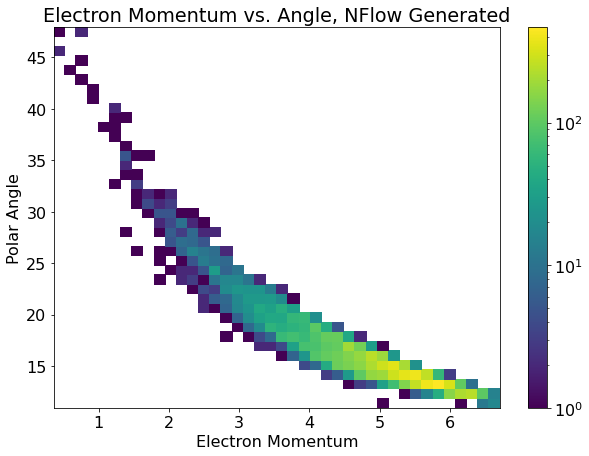

In [14]:
model.eval()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
x = x.to(device)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

p = model.prior.sample([10000, 2]).squeeze()
if device == "cpu":
  x = x.detach().numpy()
  z = z.detach().numpy()
else:
  x = x.cpu().detach().numpy()
  z = z.cpu().detach().numpy()
  p = p.cpu()

fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')


zs = model.sample(10000)
z = zs[-1]
if device == "cpu":
  z = z.detach().numpy()
else:
  z = z.cpu().detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['NFlow Model','Physics Model'])
plt.title('NFlow Generated Data vs. Physics Model Training Data')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Electron Momentum vs. Angle, Physics Model')
plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()


fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron Momentum vs. Angle, NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

##Test with normal distirbution.
The prior can be normal distributions. We can test the results with the same architecture.

In [15]:
# construct a model
# try with electron momentum magintude and polar angle only
prior = MultivariateNormal(torch.zeros(2, device = device), torch.eye(2, device = device)) # Normal distribution
# prior = TransformedDistribution(Uniform(torch.zeros(2, device = device), torch.ones(2, device = device)), SigmoidTransform().inv) # Logistic distribution
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model
model = NormalizingFlowModel(prior, flows, device = device)
model.to(device)

NormalizingFlowModel(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): AffineHalfFlow(
        (t_cond): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=24, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=24, out_features=24, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=24, out_features=24, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=24, out_features=1, bias=True)
          )
        )
      )
      (1): AffineHalfFlow(
        (t_cond): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=24, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=24, out_features=24, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=24, out_features=24, bias=True)
            (5): LeakyReLU(neg

In [16]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [17]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    x = x.to(device)
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))

Start Time = 19:25:32
On step 0 - loss 232104.06, Current Running Time = 0.03 seconds
On step 100 - loss 35262.06, Current Running Time = 2.16 seconds
On step 200 - loss 3589.53, Current Running Time = 4.25 seconds
On step 300 - loss 3011.74, Current Running Time = 6.34 seconds
On step 400 - loss 3066.30, Current Running Time = 8.40 seconds
On step 500 - loss 2896.88, Current Running Time = 10.50 seconds
On step 600 - loss 2906.08, Current Running Time = 12.60 seconds
On step 700 - loss 3026.63, Current Running Time = 14.66 seconds
On step 800 - loss 2951.48, Current Running Time = 16.74 seconds
On step 900 - loss 3037.79, Current Running Time = 18.81 seconds
On step 1000 - loss 3069.56, Current Running Time = 20.92 seconds
On step 1100 - loss 2973.10, Current Running Time = 23.01 seconds
On step 1200 - loss 2904.56, Current Running Time = 25.09 seconds
On step 1300 - loss 2988.49, Current Running Time = 27.15 seconds
On step 1400 - loss 2912.47, Current Running Time = 29.30 seconds
On

Text(0, 0.5, 'Loss')

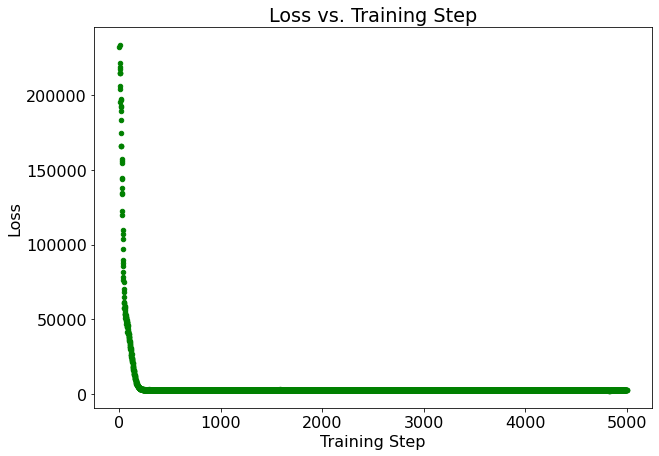

In [20]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(losses)),losses, c='g', s=20)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

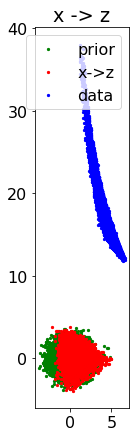

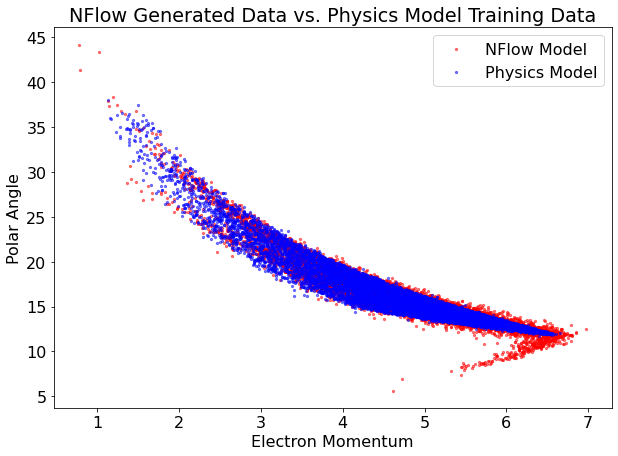

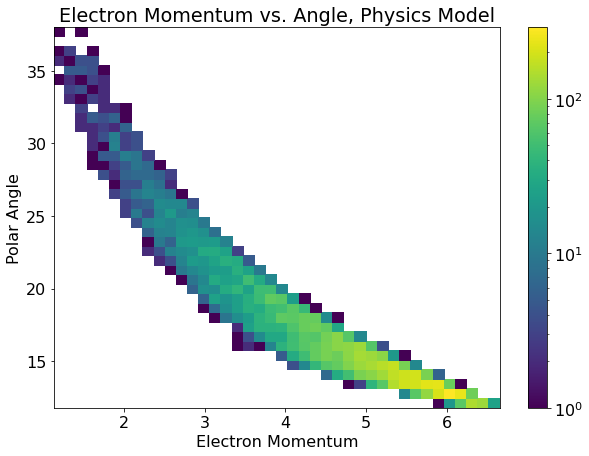

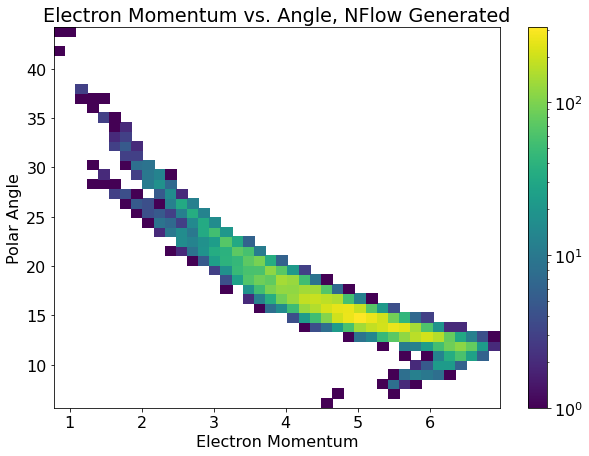

In [23]:
model.eval()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
x = x.to(device)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

p = model.prior.sample([10000, 2]).squeeze()

if device == "cpu":
  x = x.detach().numpy()
  z = z.detach().numpy()
else:
  x = x.cpu().detach().numpy()
  z = z.cpu().detach().numpy()
  p = p.cpu()

fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')


zs = model.sample(10000)
z = zs[-1]
if device == "cpu":
  z = z.detach().numpy()
else:
  z = z.cpu().detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['NFlow Model','Physics Model'])
plt.title('NFlow Generated Data vs. Physics Model Training Data')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Electron Momentum vs. Angle, Physics Model')
plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()


fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron Momentum vs. Angle, NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()